<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigureS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Importe libraries and functions
!pip install pingouin > /dev/null 2>&1
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pingouin as pg
import os
import warnings
from scipy.stats import ttest_rel

warnings.filterwarnings("ignore")

def add_sig_line(ax, x1, x2, y, p_val, h=1):
    if p_val < 0.0001:
        stars = '****'
    elif p_val < 0.001:
        stars = '***'
    elif p_val < 0.01:
        stars = '**'
    elif p_val < 0.05:
        stars = '*'
    else:
        return
    ax.plot([x1, x2], [y + h, y + h], lw=1.2, c='darkgray')
    ax.text((x1 + x2) / 2, y + h + 1.5, stars, ha='center', va='center', fontsize=11, fontweight='bold')


The system cannot find the path specified.


Exploring paired t-test p-value:
0.17166252
Seeking paired t-test p-value:
0.00000004
ANOVA result:
            Source            SS  ddof1  ddof2            MS           F  \
0             mode   8296.800174      1      9   8296.800174  220.259894   
1         behavior  25785.237674      1      9  25785.237674  239.740457   
2  mode * behavior   9993.501562      1      9   9993.501562  231.919997   

          p-unc     p-GG-corr       ng2  eps  
0  1.237342e-07  1.237342e-07  0.746533  1.0  
1  8.561355e-08  8.561355e-08  0.901512  1.0  
2  9.889836e-08  9.889836e-08  0.780104  1.0  
Post-hoc pairwise comparison with correction:
                  A                 B             T      p-corr
0   empty_Exploring     empty_Seeking  -6.975891972 0.000389732
1   empty_Exploring  social_Exploring   1.485158046 1.000000000
2   empty_Exploring    social_Seeking -19.007636105 0.000000085
3     empty_Seeking  social_Exploring   6.476032059 0.000687630
4     empty_Seeking    social_Seeking -17

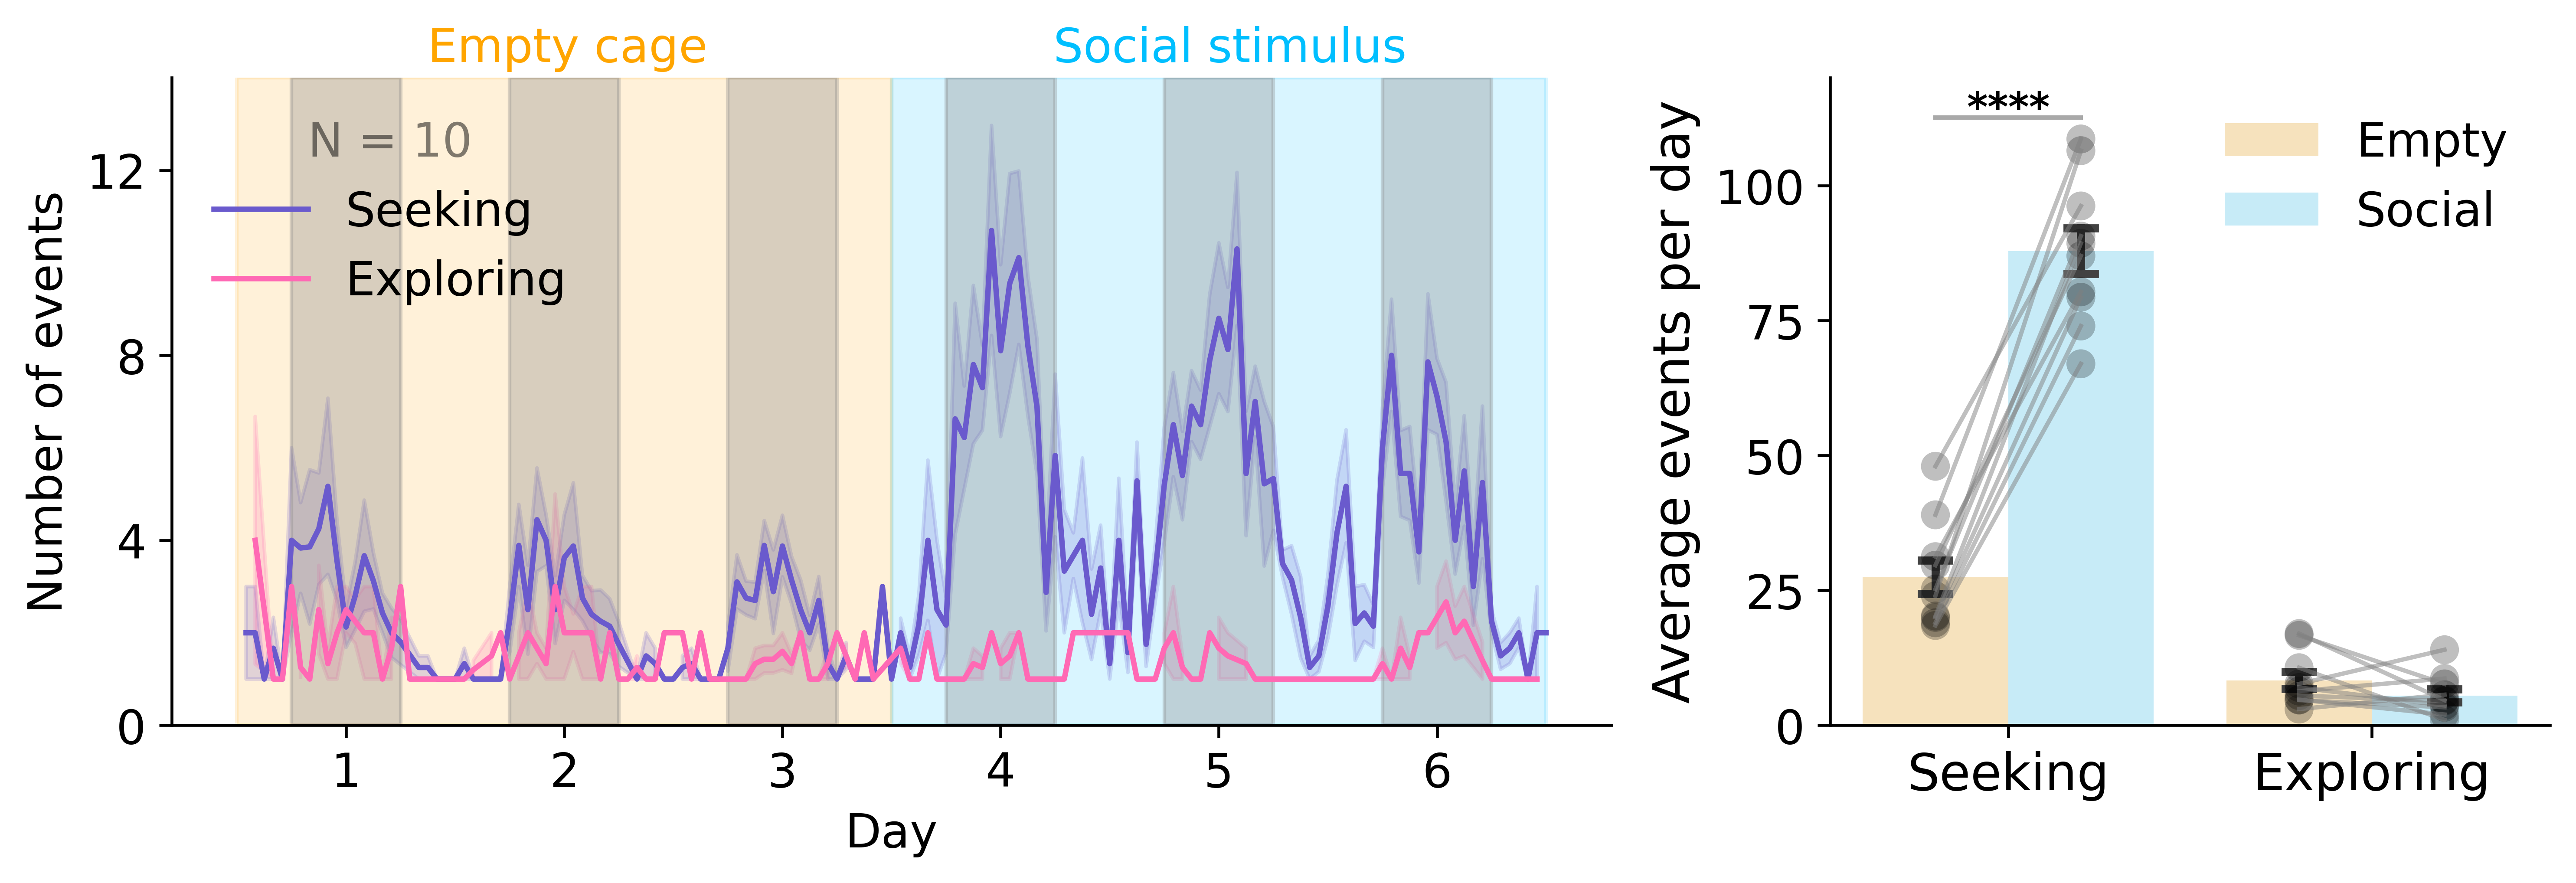

In [2]:
# @title Figure S2A-B
# Load and preprocess data
df_a = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2026/main/Data/data_FigureS2a.csv")
df_b = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2026/main/Data/data_FigureS2b.csv")

# Color palettes and orders
custom_palette = {"Seeking": "slateblue", "Exploring": "hotpink"}
interaction_order = ["Seeking", "Exploring"]
mode_order = ["empty", "social"]

# Create combined figure with 2:1 ratio
fig = plt.figure(figsize=(10, 3.5), dpi=600)
gs = fig.add_gridspec(1, 2, width_ratios=[3, 1.5])

# === LEFT PLOT: Time-course ===
ax1 = fig.add_subplot(gs[0, 0])
xtick_positions = range(-60, 61, 24)
xtick_labels = [1, 2, 3, 4, 5, 6]

ax1.axvspan(-72, 0, color='orange', alpha=0.15)
ax1.axvspan(0, 72, color='deepskyblue', alpha=0.15)

sns.lineplot(data=df_a, x="hoursfloor", y="event", hue="behavior",
             errorbar='se', palette=custom_palette,
             hue_order=interaction_order, ax=ax1)

for start in range(-66, 73, 24):
    ax1.axvspan(start, start + 12, color="grey", alpha=0.3)

ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, fontsize=13)
ax1.set_yticks(ax1.get_yticks())
ax1.tick_params(axis="y", which="both", left=True, right=False, labelsize=13)
ax1.yaxis.set_major_locator(MaxNLocator(nbins=4, integer=True))

ax1.set_xlabel("Day", fontsize=13)
ax1.set_ylabel("Number of events", fontsize=13)
ax1.text(0.275, 1.025, "Empty cage", fontsize=13, color='orange', transform=ax1.transAxes, ha='center')
ax1.text(0.735, 1.025, "Social stimulus", fontsize=13, color='deepskyblue', transform=ax1.transAxes, ha='center')
legend1 = ax1.legend(title=f'N = {len(df_a["device_number"].unique())}', title_fontsize=13, loc="upper left", frameon=False, fontsize=13)
legend1.get_title().set_alpha(0.5)
sns.despine(ax=ax1)

# === RIGHT PLOT: Bar and Strip ===
ax2 = fig.add_subplot(gs[0, 1])

sns.barplot(data=df_b, x="behavior", y="event", hue="mode",
            errorbar="se", capsize=0.15,
            order=interaction_order, hue_order=mode_order,
            palette={"empty": "#FFE5B4", "social": "#BFEFFF"},
            ax=ax2)

sns.stripplot(data=df_b, x="behavior", y="event", hue="mode",
              dodge=True, jitter=False, palette=['black']*4,
              alpha=0.25, size=8, zorder=2,
              order=interaction_order, hue_order=mode_order,
              legend=False, ax=ax2)

# Connect dots
x_positions = {"Seeking": 0, "Exploring": 1}
for interaction in df_b["behavior"].unique():
    subset = df_b[df_b["behavior"] == interaction]
    empty = subset[subset["mode"] == "empty"].reset_index(drop=True)
    social = subset[subset["mode"] == "social"].reset_index(drop=True)
    for i in range(len(empty)):
        ax2.plot(
            [x_positions[interaction] - 0.2, x_positions[interaction] + 0.2],
            [empty.loc[i, "event"], social.loc[i, "event"]],
            color="gray", alpha=0.5, linewidth=1.2, zorder=4
        )

for interaction in df_b["behavior"].unique():
    subset = df_b[df_b["behavior"] == interaction]
    empty_data = subset[subset["mode"] == "empty"]["event"].reset_index(drop=True)
    social_data = subset[subset["mode"] == "social"]["event"].reset_index(drop=True)
    _, p_value = ttest_rel(empty_data, social_data)
    y_max = subset["event"].max()
    x_center = x_positions[interaction]
    print(f'{interaction} paired t-test p-value:')
    print(f'{p_value:.8f}')
    add_sig_line(ax2, x_center - 0.2, x_center + 0.2, y_max, p_value, h=4)

# We'll keep only relevant columns
df_anova = df_b[["device_number", "mode", "behavior", "event"]].copy()

# Run repeated measures ANOVA with two within-subject factors: mode and behavior
aov = pg.rm_anova(dv="event", within=["mode", "behavior"], subject="device_number", data=df_anova, detailed=True)
print('ANOVA result:')
print(aov)

# Make sure you're using the right data
df_posthoc = df_b[["device_number", "mode", "behavior", "event"]].copy()

# Create a new column combining mode and behavior
df_posthoc["condition"] = df_posthoc["mode"] + "_" + df_posthoc["behavior"]

# Run post-hoc pairwise comparisons with correction
pairwise = pg.pairwise_tests(
    data=df_posthoc,
    dv="event",
    within="condition",
    subject="device_number",
    padjust="bonf",  # Bonferroni correction
    # effsize="cohen"
)

# Display results
print("Post-hoc pairwise comparison with correction:")
with pd.option_context('display.float_format', '{:.9f}'.format):
    print(pairwise[["A", "B", "T", "p-corr"]])


# Final formatting
ax2.set_ylabel("Average events per day", fontsize=14)
ax2.set_xlabel("")
ax2.set_xticklabels([label.capitalize() for label in interaction_order], fontsize=14)
ax2.set_yticks(ax2.get_yticks())
ax2.tick_params(axis="y", which="both", left=True, right=False, labelsize=13)
ax2.yaxis.set_major_locator(MaxNLocator(5))
sns.despine(ax=ax2)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend('',frameon=False)
ax2.legend(title_fontsize=13, handles=handles[:2], labels=["Empty", "Social"],
           fontsize=13, frameon=False, loc="upper right")

plt.tight_layout()
plt.show()